In [ ]:
import cv2
import gdown
import matplotlib.pyplot as plt


# Import Videos

In [ ]:
base_url = 'https://drive.google.com/uc?id='
book_video = base_url + '12-v0UI1OjLI3wxVP1VPfRBODtNplfIIj'
panda_video = base_url + '1te5I3FPBQrGtb1__DON8_cFLD1FDJ_yx'
book_cover_photo = base_url + '1aIbGkm6uCsZUfNhc1e9bk-hMMWZ1-HRf'
gdown.download(book_video)
gdown.download(panda_video)
gdown.download(book_cover_photo)

Downloading...
From: https://drive.google.com/uc?id=12-v0UI1OjLI3wxVP1VPfRBODtNplfIIj
To: /content/book.mov
100%|██████████| 28.5M/28.5M [00:00<00:00, 33.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1te5I3FPBQrGtb1__DON8_cFLD1FDJ_yx
To: /content/source.mov
100%|██████████| 6.29M/6.29M [00:00<00:00, 37.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aIbGkm6uCsZUfNhc1e9bk-hMMWZ1-HRf
To: /content/cover.jpg
100%|██████████| 117k/117k [00:00<00:00, 33.2MB/s]


'cover.jpg'

# General Functions

In [ ]:
def display_image(image, title):
    plt.figure(figsize=(8, 8))
    if len(image.shape) == 3:  # Color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
    else:  # Grayscale image
        plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Getting Correspondences

## Extract and Save Frame

In [ ]:
def get_first_frame(video_path):
    '''
    Input: .mov file path
    Output: first frame of video as numpy array
    '''
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    return frame



book_frame = get_first_frame('/content/book.mov')
cv2.imwrite('book_frame.jpg', book_frame) # save first frame as jpg


True

## Get SIFT Keypoints

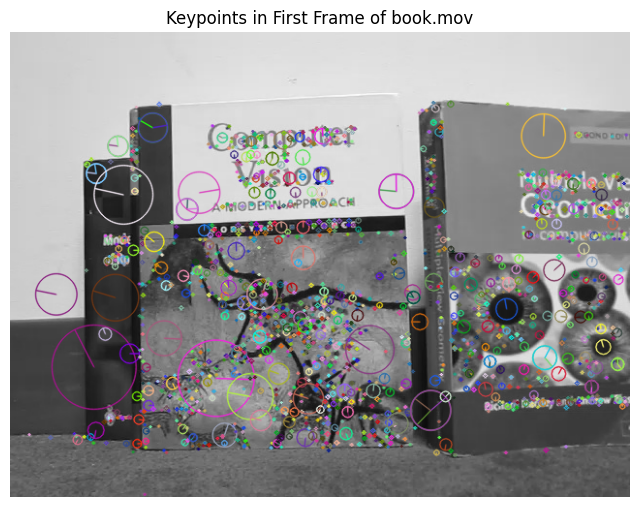

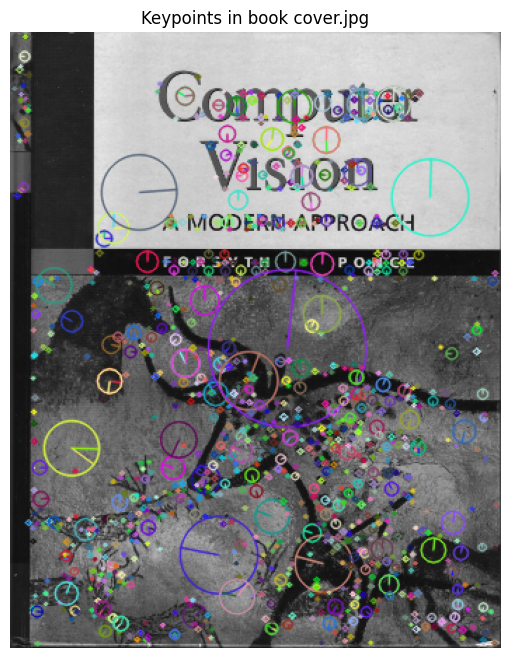

In [ ]:
book_frame = cv2.imread('/content/book_frame.jpg')
book_cover = cv2.imread('/content/cover.jpg')

# Convert to grayscale
gray_book_frame = cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY)
gray_book_cover = cv2.cvtColor(book_cover, cv2.COLOR_BGR2GRAY)


# Initialize SIFT detector
sift = cv2.SIFT_create()


# Detect keypoints and compute descriptors
keypoints_frame, descriptors_frame = sift.detectAndCompute(gray_book_frame, None)
keypoints_book, descriptors_book = sift.detectAndCompute(gray_book_cover, None)

# Draw keypoints on the images
frame_with_keypoints = cv2.drawKeypoints(
    gray_book_frame, keypoints_frame, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
book_with_keypoints = cv2.drawKeypoints(
    gray_book_cover, keypoints_book, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Display the images with keypoints
display_image(frame_with_keypoints, "Keypoints in First Frame of book.mov")
display_image(book_with_keypoints, "Keypoints in book cover.jpg")

## Match Keypoints

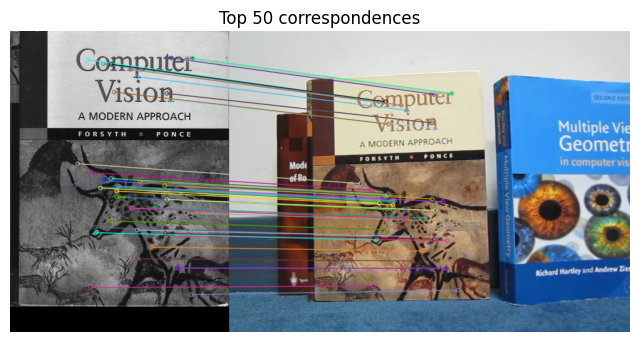

In [ ]:
# Initialize Brute Force Matcher
bf = cv2.BFMatcher()

# Perform KNN matching with k=2
matches = bf.knnMatch(descriptors_book, descriptors_frame, k=2)


# Apply ratio test to filter good matches
ratio_thresh = 0.3
good_matches = []
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

# Sort matches based on distance (best matches first)
good_matches = sorted(good_matches, key=lambda x: x.distance)

# Choose top 50 correspondences
top_matches = good_matches[:50]

# Plotting the matches
matched_image = cv2.drawMatches(
    book_cover, keypoints_book,
    book_frame, keypoints_frame,
    top_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

display_image(matched_image, "Top 50 correspondences")

# Computing Homography Matrix

In [ ]:
import numpy as np

def compute_homography(correspondences):
    """
    Computes the homography matrix from point correspondences.

    Parameters:
        correspondences (list of tuples): A list of at least 4 pairs of points.
                                          Each pair is ((x, y), (x', y')).

    Returns:
        H (numpy.ndarray): A 3x3 homography matrix.
    """
    # Construct the A matrix
    A = []
    for (x, y), (x_prime, y_prime) in correspondences:
        A.append([x, y, 1, 0, 0, 0, -x_prime * x, -x_prime * y, -x_prime])
        A.append([0, 0, 0, x, y, 1, -y_prime * x, -y_prime * y, -y_prime])
    A = np.array(A)

    # Perform SVD
    U, S, Vt = np.linalg.svd(A)

    # The last row of Vt (or last column of V) is the solution
    H = Vt[-1].reshape((3, 3))

    # Normalize H so that H[2, 2] = 1
    H = H / H[2, 2]

    return H

In [ ]:
src_points = []
dst_points = []

for match in top_matches:
    # Retrieve corresponding keypoints
    query_pt = keypoints_book[match.queryIdx].pt
    train_pt = keypoints_frame[match.trainIdx].pt
    # Add to point lists
    src_points.append(query_pt)
    dst_points.append(train_pt)

# Print or use the correspondences
print("Source Points (Query Image):\n", src_points)
print("Destination Points (Train Image):\n", dst_points)

#built-in homography
#Convert to NumPy arrays (required for cv2.findHomography)
src_points_np = np.float32(src_points).reshape(-1, 1, 2)
dst_points_np = np.float32(dst_points).reshape(-1, 1, 2)

H, mask = cv2.findHomography(src_points_np, dst_points_np, cv2.RANSAC, 5.0)
print("CV2 Homography Matrix:\n", H)

#using our implementation for computing homography matrix
correspondences = list(zip(src_points, dst_points))
print("Correspondences:",correspondences)

H = compute_homography(correspondences)
print("Our Homography Matrix:\n", H)

Source Points (Query Image):
 [(129.8494873046875, 225.25643920898438), (149.6501922607422, 236.7246856689453), (169.99110412597656, 254.7916717529297), (191.7931365966797, 60.7531852722168), (288.9967346191406, 419.9022216796875), (167.90914916992188, 248.2516326904297), (107.89212799072266, 211.0980682373047), (155.9535675048828, 238.7621612548828), (249.93177795410156, 99.069580078125), (249.93177795410156, 99.069580078125), (191.7931365966797, 60.7531852722168), (149.6501922607422, 236.7246856689453), (135.7626953125, 312.61102294921875), (271.6427307128906, 325.9288024902344), (136.9944305419922, 321.0356140136719), (256.6546936035156, 110.03197479248047), (148.19772338867188, 51.846981048583984), (265.5174560546875, 251.53009033203125), (170.22691345214844, 264.0513916015625), (246.47567749023438, 246.05677795410156), (257.097412109375, 42.641536712646484), (268.07806396484375, 377.64739990234375), (157.84310913085938, 302.3231506347656), (166.03036499023438, 96.92924499511719), 

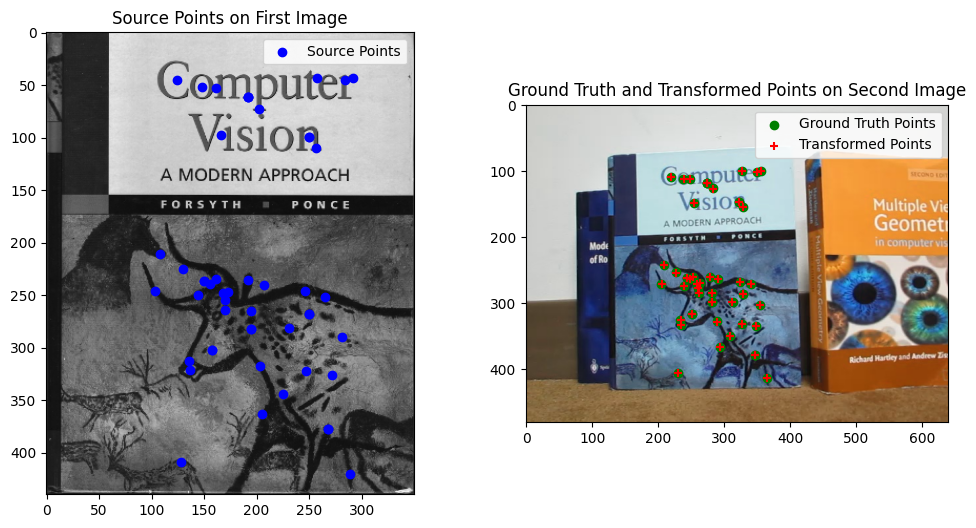

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def verify_homography_mapping(H, src_points, dst_points, image_src, image_dst):
    """
    Verifies the computed homography by mapping points from one image to the other
    and displaying them.

    Parameters:
        H (numpy.ndarray): The computed 3x3 homography matrix.
        src_points (numpy.ndarray): Source points (clicked points) in the first image (n, 1, 2).
        dst_points (numpy.ndarray): Corresponding points in the second image (n, 1, 2).
        image_src (numpy.ndarray): First image.
        image_dst (numpy.ndarray): Second image.
    """
    # Convert source points to homogeneous coordinates
    src_points = np.float32(src_points)
    dst_points = np.float32(dst_points)
    src_points_homogeneous = cv2.convertPointsToHomogeneous(src_points).reshape(-1, 3).T  # Shape: (3, n)

    # Transform points using the homography matrix
    transformed_points_homogeneous = np.dot(H, src_points_homogeneous)  # Shape: (3, n)

    # Normalize transformed points to Cartesian coordinates
    transformed_points_homogeneous /= transformed_points_homogeneous[2]  # Divide by w
    transformed_points = transformed_points_homogeneous[:2].T  # Back to shape (n, 2)

    # Convert dst_points to Cartesian for visualization
    dst_points_cartesian = dst_points.reshape(-1, 2)

    # Visualization
    # Plot the source points on the source image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_src, cmap='gray')
    plt.scatter(src_points[:,0], src_points[:,1], color='blue', label='Source Points')
    plt.title("Source Points on First Image")
    plt.legend()

    # Plot the transformed points and ground truth points on the second image
    plt.subplot(1, 2, 2)
    plt.imshow(image_dst, cmap='gray')
    plt.scatter(dst_points_cartesian[:, 0], dst_points_cartesian[:, 1], color='green', label='Ground Truth Points')
    plt.scatter(transformed_points[:, 0], transformed_points[:, 1], color='red', label='Transformed Points', marker='+')
    plt.title("Ground Truth and Transformed Points on Second Image")
    plt.legend()

    plt.show()

verify_homography_mapping(H, src_points, dst_points, book_cover, book_frame)

# Calculating Book Coordinates

[[  0.   0.   1.]
 [350.   0.   1.]
 [  0. 440.   1.]
 [350. 440.   1.]]
Transformed corner points in the second image:
 [[119.54613549  77.79288387]
 [402.89301424  61.52880096]
 [125.18966157 434.42145355]
 [418.56675644 430.01328227]]


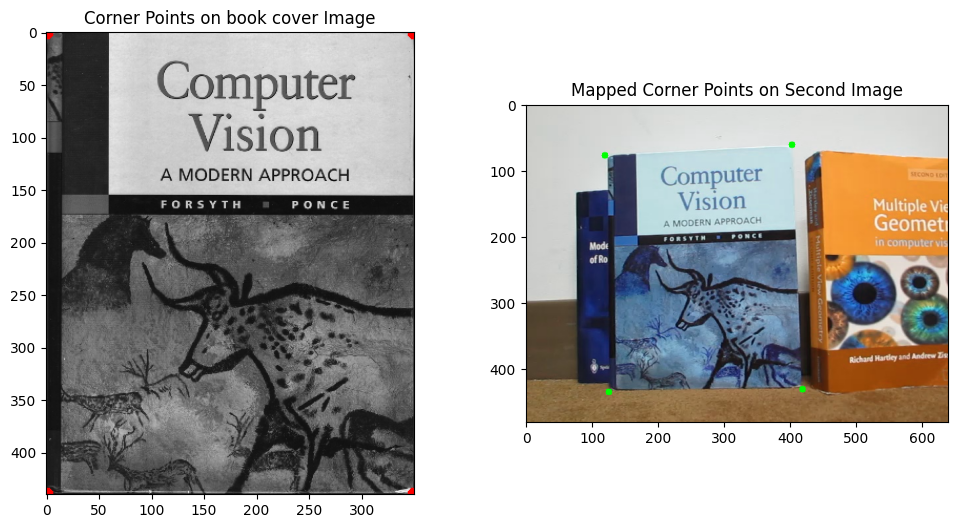

In [ ]:
#get corner points of book cover.
corner_points = np.float32([[0, 0], [book_cover.shape[1], 0], [0, book_cover.shape[0]], [book_cover.shape[1], book_cover.shape[0]]])

# Convert to homogeneous coordinates (adding 1 to each point)
bookcover_corners_homogeneous = np.hstack([corner_points, np.ones((corner_points.shape[0], 1))])
print(bookcover_corners_homogeneous)
corners_second_image_homogeneous = np.dot(H, bookcover_corners_homogeneous.T).T  # Shape (4, 3)

# Normalize the points by dividing by the third coordinate (w)
corners_second_image = corners_second_image_homogeneous[:, :2] / corners_second_image_homogeneous[:, 2:3]

# Print the transformed corner points
print("Transformed corner points in the second image:\n", corners_second_image)

# Display the result on the second image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(book_cover, cmap='gray')
book_cover_with_corners = book_cover.copy()  # Copy to avoid modifying the original
for point in corner_points:
    cv2.circle(book_cover_with_corners, tuple(point.astype(int)), 7, (255, 0, 0), -1)  # Green circles

# Plot the second image with the mapped corners
plt.imshow(book_cover_with_corners, cmap='gray')
plt.title("Corner Points on book cover Image")


plt.subplot(1, 2, 2)
book_frame_with_corners = book_frame.copy()  # Copy to avoid modifying the original
for point in corners_second_image:
    cv2.circle(book_frame_with_corners, tuple(point.astype(int)), 5, (0, 255, 0), -1)  # Green circles

# Plot the second image with the mapped corners
plt.imshow(book_frame_with_corners, cmap='gray')
plt.title("Mapped Corner Points on Second Image")
plt.show()
